# Heart Disease Prediction - EDA and Modeling

This notebook covers the following steps:
1. Data Acquisition and Cleaning
2. Exploratory Data Analysis (EDA)
3. Feature Engineering
4. Model Development and Evaluation
5. Experiment Tracking with MLflow

In [ ]:
#!pip install mlflow

   ---------------------------------------- 0.0/9.1 MB ? eta -:--:--
   ---------------------------------------  8.9/9.1 MB 50.3 MB/s eta 0:00:01
   ---------------------------------------- 9.1/9.1 MB 43.3 MB/s eta 0:00:00
   ---------------------------------------- 0.0/2.5 MB ? eta -:--:--
   ---------------------------------------- 2.5/2.5 MB 36.2 MB/s eta 0:00:00
   ---------------------------------------- 0.0/1.4 MB ? eta -:--:--
   ---------------------------------------- 1.4/1.4 MB 23.3 MB/s eta 0:00:00
   ---------------------------------------- 0.0/774.7 kB ? eta -:--:--
   --------------------------------------- 774.7/774.7 kB 32.0 MB/s eta 0:00:00


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, confusion_matrix, classification_report
import mlflow
import mlflow.sklearn
import os

import warnings
warnings.filterwarnings('ignore')

sns.set(style="whitegrid")

## 1. Data Acquisition and Cleaning

In [4]:
# Load data
df = pd.read_csv('../data/heart_disease.csv')
df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63.0,1.0,1.0,145.0,233.0,1.0,2.0,150.0,0.0,2.3,3.0,0.0,6.0,0
1,67.0,1.0,4.0,160.0,286.0,0.0,2.0,108.0,1.0,1.5,2.0,3.0,3.0,2
2,67.0,1.0,4.0,120.0,229.0,0.0,2.0,129.0,1.0,2.6,2.0,2.0,7.0,1
3,37.0,1.0,3.0,130.0,250.0,0.0,0.0,187.0,0.0,3.5,3.0,0.0,3.0,0
4,41.0,0.0,2.0,130.0,204.0,0.0,2.0,172.0,0.0,1.4,1.0,0.0,3.0,0


In [5]:
# Check for missing values
print("Missing values:\n", df.isnull().sum())

# The 'ca' and 'thal' columns had '?' in original UCI dataset, 
# handled during download by setting na_values='?'
df = df.fillna(df.median())
print("\nMissing values after imputation:\n", df.isnull().sum())

Missing values:
 age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
slope       0
ca          4
thal        2
target      0
dtype: int64

Missing values after imputation:
 age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
slope       0
ca          0
thal        0
target      0
dtype: int64


## 2. Exploratory Data Analysis (EDA)

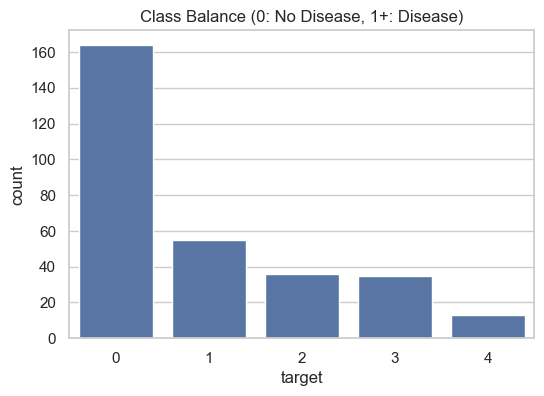

In [6]:
# Class Balance
plt.figure(figsize=(6, 4))
sns.countplot(x='target', data=df)
plt.title('Class Balance (0: No Disease, 1+: Disease)')
plt.show()

# Convert target to binary: 0 vs 1+ (UCI heart disease target > 0 means disease)
df['target'] = df['target'].apply(lambda x: 1 if x > 0 else 0)

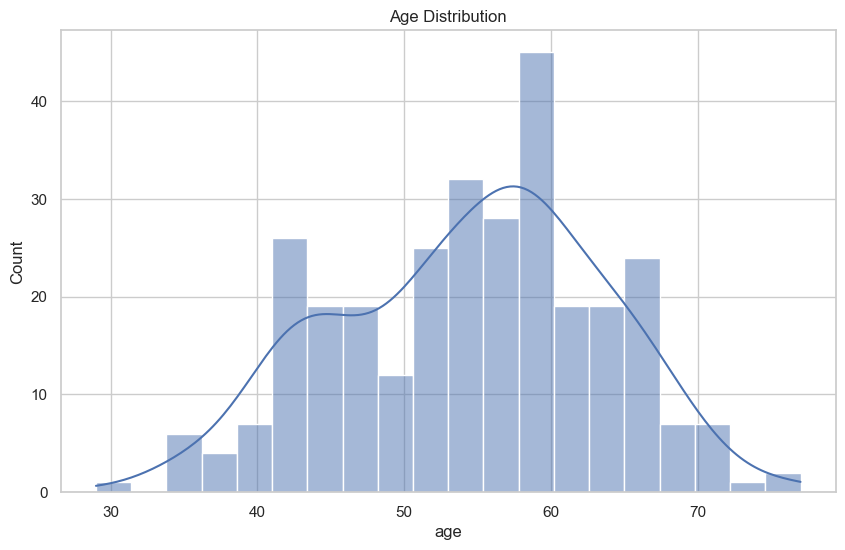

In [7]:
# Age Distribution
plt.figure(figsize=(10, 6))
sns.histplot(df['age'], kde=True, bins=20)
plt.title('Age Distribution')
plt.show()

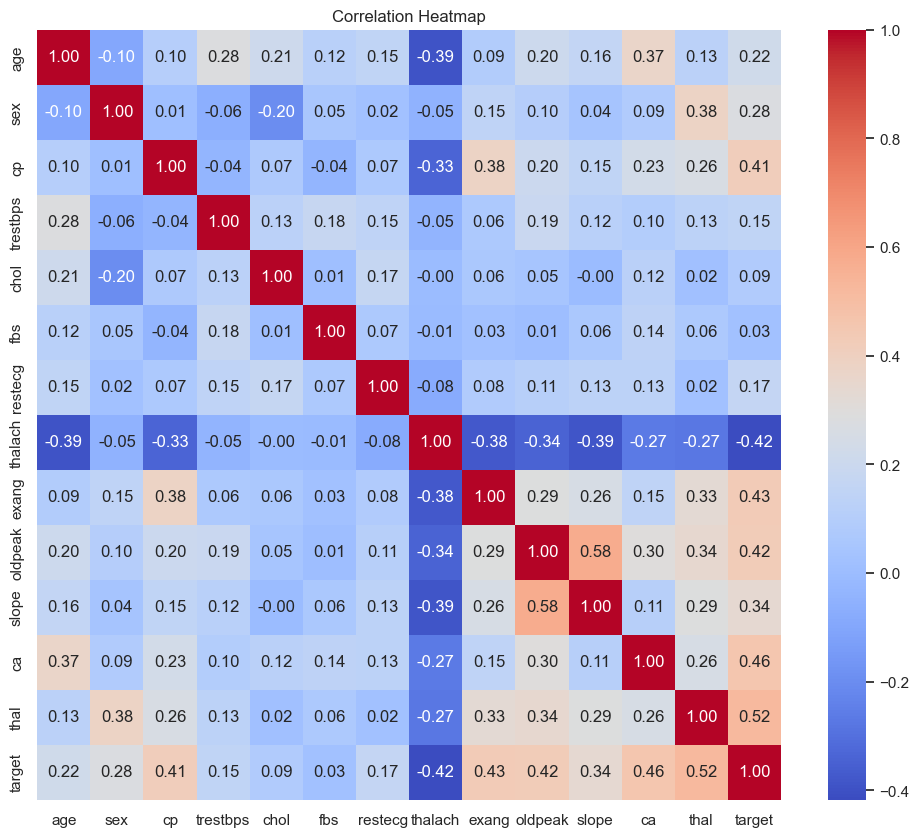

In [8]:
# Correlation Heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap')
plt.show()

## 3. Feature Engineering & Preprocessing

In [9]:
X = df.drop('target', axis=1)
y = df['target']

# Numerical and Categorical columns
num_cols = ['age', 'trestbps', 'chol', 'thalach', 'oldpeak']
cat_cols = ['sex', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'ca', 'thal']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore'), cat_cols)
    ]
)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## 4. Model Development & Experiment Tracking

In [10]:
def train_and_log_model(model_name, model, X_train, y_train, X_test, y_test):
    with mlflow.start_run(run_name=model_name):
        pipeline = Pipeline(steps=[
            ('preprocessor', preprocessor),
            ('classifier', model)
        ])
        
        pipeline.fit(X_train, y_train)
        y_pred = pipeline.predict(X_test)
        y_prob = pipeline.predict_proba(X_test)[:, 1]
        
        metrics = {
            "accuracy": accuracy_score(y_test, y_pred),
            "precision": precision_score(y_test, y_pred),
            "recall": recall_score(y_test, y_pred),
            "roc_auc": roc_auc_score(y_test, y_prob)
        }
        
        mlflow.log_params(model.get_params())
        mlflow.log_metrics(metrics)
        mlflow.sklearn.log_model(pipeline, "model")
        
        print(f"--- {model_name} Results ---")
        for k, v in metrics.items():
            print(f"{k}: {v:.4f}")
        print(classification_report(y_test, y_pred))
        
        return pipeline

In [11]:
# Train Logistic Regression
lr_model = LogisticRegression(max_iter=1000)
lr_pipeline = train_and_log_model("Logistic_Regression", lr_model, X_train, y_train, X_test, y_test)

2025/12/22 22:36:43 INFO mlflow.store.db.utils: Creating initial MLflow database tables...
2025/12/22 22:36:43 INFO mlflow.store.db.utils: Updating database tables
2025/12/22 22:36:43 INFO alembic.runtime.migration: Context impl SQLiteImpl.
2025/12/22 22:36:43 INFO alembic.runtime.migration: Will assume non-transactional DDL.
2025/12/22 22:36:45 INFO alembic.runtime.migration: Context impl SQLiteImpl.
2025/12/22 22:36:45 INFO alembic.runtime.migration: Will assume non-transactional DDL.
2025/12/22 22:36:45 WARNING mlflow.utils.git_utils: Failed to import Git (the Git executable is probably not on your PATH), so Git SHA is not available. Error: Failed to initialize: Bad git executable.
The git executable must be specified in one of the following ways:
    - be included in your $PATH
    - be set via $GIT_PYTHON_GIT_EXECUTABLE
    - explicitly set via git.refresh(<full-path-to-git-executable>)

All git commands will error until this is rectified.

This initial message can be silenced or 

--- Logistic_Regression Results ---
accuracy: 0.8361
precision: 0.8438
recall: 0.8438
roc_auc: 0.9159
              precision    recall  f1-score   support

           0       0.83      0.83      0.83        29
           1       0.84      0.84      0.84        32

    accuracy                           0.84        61
   macro avg       0.84      0.84      0.84        61
weighted avg       0.84      0.84      0.84        61



In [12]:
# Train Random Forest
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_pipeline = train_and_log_model("Random_Forest", rf_model, X_train, y_train, X_test, y_test)

2025/12/22 22:38:03 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


--- Random_Forest Results ---
accuracy: 0.8525
precision: 0.8966
recall: 0.8125
roc_auc: 0.9402
              precision    recall  f1-score   support

           0       0.81      0.90      0.85        29
           1       0.90      0.81      0.85        32

    accuracy                           0.85        61
   macro avg       0.85      0.85      0.85        61
weighted avg       0.86      0.85      0.85        61



In [13]:
# Save the best model (Random Forest for demonstration)
import pickle
os.makedirs('../models', exist_ok=True)
with open('../models/model.pkl', 'wb') as f:
    pickle.dump(rf_pipeline, f)
print("Model saved to models/model.pkl")

Model saved to models/model.pkl
